# 사용할 모듈 불러오기

In [1]:
# 사용할 모듈 불러오기 
# 라벨인코딩
from sklearn.preprocessing import LabelEncoder
# 그래프
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
# 기본
import numpy as np
import pandas as pd
import seaborn as sns
# 함수 사용시 사용
import re
# itertools의 product은 리스트 간의 데카르트 곱을  구하는 데 사용된다.
from itertools import product



In [2]:
# 데이터 불러오기
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")
item_categories = pd.read_csv('./data/item_categories.csv')
submission = pd.read_csv("./data/sample_submission.csv")

In [3]:
font_path = "C:/Windows/Fonts/NanumGothic.otf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

# EDA

In [4]:
def reduce_mem_usage(df, show_result=True):
    num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # 총 메모리를 Mb단위로 표현해준다. 
    start_mem = df.memory_usage().sum() / 1024**2
    # 각 열별로 데이터 타입 및 최대 최소 값 확인 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in num_types:
            c_min = df[col].min()
            c_max = df[col].max()
            # 만약 정수형이라면 
            if str(col_type)[:3] == 'int':
                # np.iinfo()해당 형이 표현 가능한 최댓값 최솟값을 출력해준다. 
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            # 만약 실수형이라면
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if show_result: 
        print('Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)'
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# shops

In [5]:
shops.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [6]:
shops.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [7]:
def clean_text(inputString):
    text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', inputString)
    return text_rmv
shops_names = shops["shop_name"].apply(clean_text)
shops_id = shops["shop_id"]
# 중복되는 이름 확인 
for i in list(zip(shops_names ,shops_id)):
    for j in list(zip(shops_names ,shops_id)):
        if (re.match('.*'+i[0]+'*.',j[0])) and (i[1]!= j[1]):
            print('code : ', i[1], ' and  ', j[1])
            print('name : ', i[0], ' and  ', j[0])
            

code :  10  and   11
name :  Жуковский ул  Чкалова 39м   and   Жуковский ул  Чкалова 39м²
code :  11  and   10
name :  Жуковский ул  Чкалова 39м²  and   Жуковский ул  Чкалова 39м 
code :  39  and   40
name :  РостовНаДону ТРК  Мегацентр Горизонт   and   РостовНаДону ТРК  Мегацентр Горизонт  Островной
code :  57  and   0
name :  Якутск Орджоникидзе  56  and    Якутск Орджоникидзе  56 фран
code :  58  and   1
name :  Якутск ТЦ  Центральный   and    Якутск ТЦ  Центральный  фран


- 위와 같이 shop id가 10:11, 39:40, 57:0, 58:1 4개의 아이디가 중복되는 것을 알 수 있다.
- 위의 데이터를 기준으로 train data의 shop id를 바꾸어준다

In [8]:
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
test["shop_id"] = test["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

# test , submission

In [9]:
test.info()  # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [10]:
submission.info() # item_cnt_day 가 아니라 item_cnt_month가 필요함을 알수가있다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


In [11]:
# test의 shop_id , item_id 기 train 데이터에 있는지 확인
diff_train_test_shop_id  = set(train['shop_id']) - set(test['shop_id'])
print('diffrent shop_id nums: ',len(diff_train_test_shop_id))
diff_test_train_item_id = set(test['item_id']) - set(train['item_id'])
print('diffrent item_id nums: ',len(diff_test_train_item_id))
diff_test_items_item_id = set(test['item_id']) - set(items['item_id'])
print('diff_test_items_itemid nums: ',len(diff_test_items_item_id))

diffrent shop_id nums:  14
diffrent item_id nums:  363
diff_test_items_itemid nums:  0


# 아하!
- test에 시간 데이터가 존재하지 않으므로 date_block_num =34 를 추가한다.
- shop_id,item_id,date_block_num을 기준으로 묶어 item_cnt_day -> item_cnt_month 로 변환한다.
- test에는 존재하지만 train에 존재하지 않는 값이 363개 존재한다.
- train에만 있는 가게가 14개 존재한다.

## Train

In [12]:
train.info() # null 값이 모든데이터에 존재 하지 않는다. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [13]:
#  date의 자료형을 object  -> dattime 으로 바꾸고 싶다. 
# 변환하는 과정  ->
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")
train["date"].head(3) 

0   2013-01-02
1   2013-01-03
2   2013-01-05
Name: date, dtype: datetime64[ns]

In [14]:
train.describe(include = 'all')

C:\Users\AW17R4\AppData\Local\Temp\ipykernel_2792\2740853986.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  train.describe(include = 'all')


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
unique,1034,NaN,NaN,NaN,NaN,NaN
top,2013-12-28 00:00:00,NaN,NaN,NaN,NaN,NaN
freq,9434,NaN,NaN,NaN,NaN,NaN
first,2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
last,2015-10-31 00:00:00,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.456991e+01,3.330172e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,NaN,9.422988e+00,1.614678e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,NaN,0.000000e+00,2.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,NaN,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00


- 2013-01-01 00:00:00 ~ 2015-10-31 00:00:00 까지의 1034일간의 데이터임을 알수있다.
- item_price은 평균과 중위값의 차이가 심한 것으로 보아 이상치가 존재함을 알 수 있디.
- item_cnt_day 는일,이,삼 분위수가 1인데 비해 평균은 대략 1.2 최대값은 2168로 이상치가 존재한다.
- item_cnt_day, item_price에 최소값들은 음수이다.

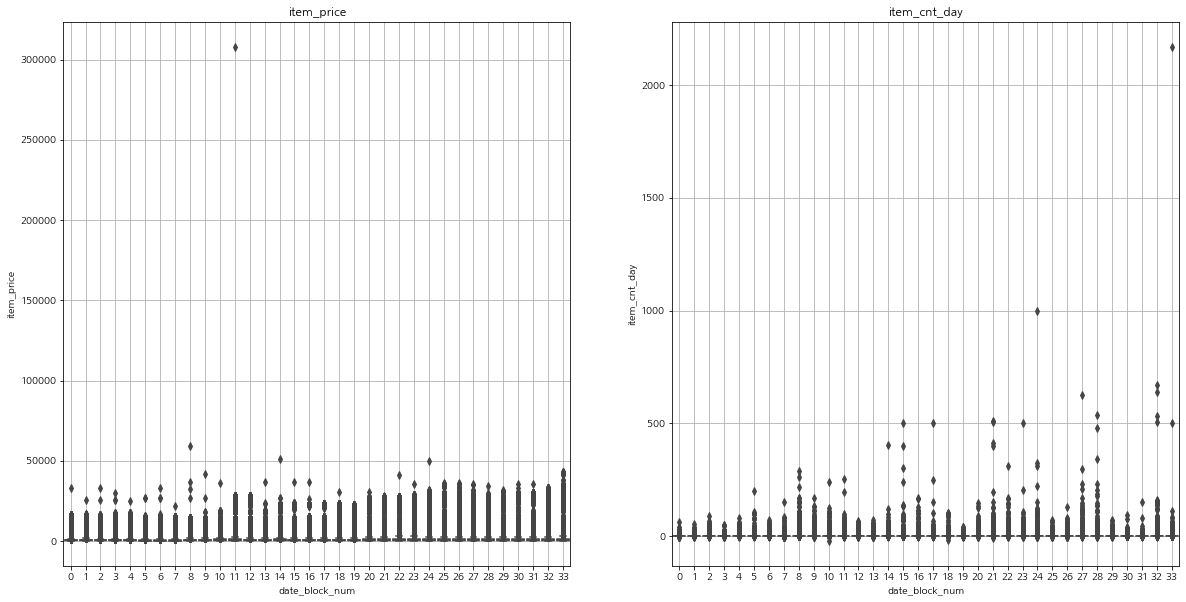

In [15]:
def price_item_cnt_day_boxplot():
    plt.figure(figsize = (20,10))
    # item_price 의 박스플롯
    plt.subplot(1,2,1)
    sns.boxplot(x = 'date_block_num' , y= 'item_price',data =train)
    plt.title('item_price')
    plt.grid()
    # item_cnt_day의 박스 플롯
    plt.subplot(1,2,2)
    sns.boxplot(x = 'date_block_num' , y= 'item_cnt_day',data =train)
    plt.title('item_cnt_day')
    plt.grid()
price_item_cnt_day_boxplot()

- 다음은 date_block_num 별로 item_price의 boxplot이다.  
- 위의 그래프를 기준으로 item_price는 50000 이상 , item_cnt_day 는 1000 이상을 이상치로서 train에서 제거한다.  
- 또한 판매되는 수량을 구하는 것이 목적이므로 0미만의 값을 제거한다.

In [16]:
condition_for_drop = ((train["item_price"] >= 50000) | (train["item_price"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

condition_for_drop = ((train["item_cnt_day"] >= 1000) | (train["item_cnt_day"] < 0))
train.drop(train[condition_for_drop].index, axis = 0 , inplace=True)

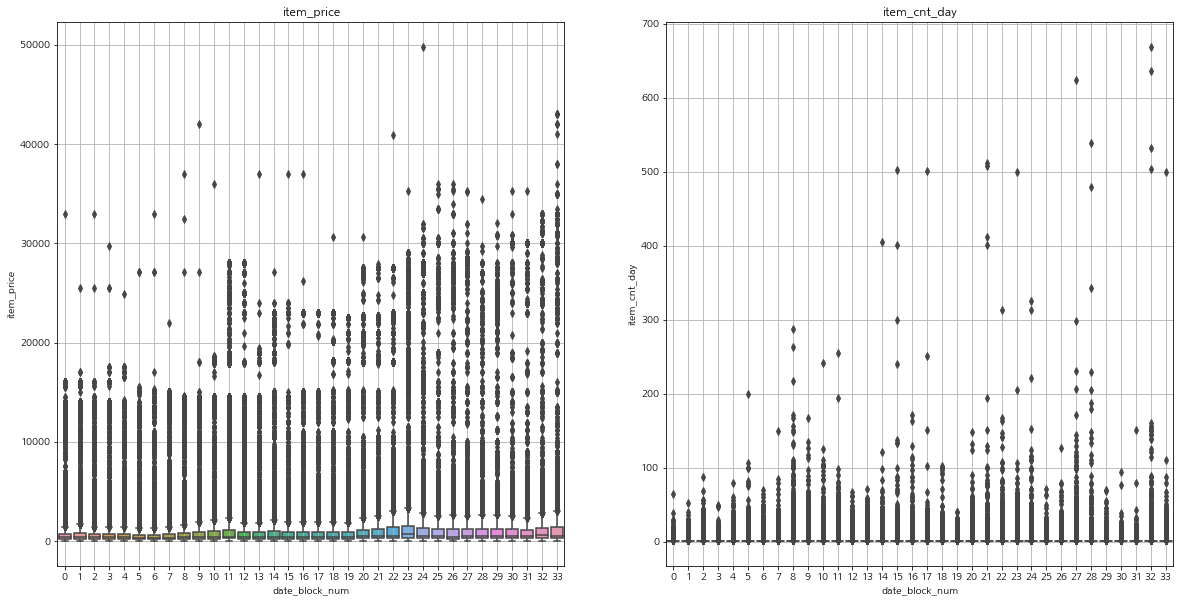

In [17]:
# 제거 후의 boxplot
price_item_cnt_day_boxplot()

### train 에만 존재하는 가게 지우기 

In [18]:
train = train[train['shop_id'].isin(test['shop_id'].unique())]

### train 에 item_revenue 추가

In [19]:
train['item_revenue'] = train.item_price * train.item_cnt_day

### train 모든 가게에 대해 파는 아이템 조합

In [20]:
'''
방법 1
itertools 의 product을 사용하여
각 달 아이템이 팔린 가게와 아이템 , data_num_block의 조합을 출력한다. 
'''

sales_df = []
for i in range(34):
    all_shops = train.loc[train['date_block_num'] == i , 'shop_id'].unique()
    all_items = train.loc[train['date_block_num'] == i , 'item_id'].unique()
    sales_df.append(np.array(list(product([i] , all_shops ,all_items))))
base_feature_names = ['date_block_num','shop_id','item_id']
# np.vstack 세로 결합 (열의 갯수가 같아야 한다.)
sales_df = pd.DataFrame(np.vstack(sales_df) , columns = base_feature_names)

In [21]:
'''
doing
item_cnt_day >> item_cnt_month 
doing
item_price  >> item_price_mean_month
'''
train_item_cnt_month  = train.pivot_table(index = base_feature_names ,
                                          values = ['item_cnt_day','item_price'] , 
                                          aggfunc ={'item_cnt_day': np.sum,
                                                   'item_price': np.mean})
sales_df = pd.merge(sales_df,
                      train_item_cnt_month.reset_index(),
                      on = base_feature_names,
                      how= 'left')

sales_df.rename(columns= {'item_cnt_day':'item_cnt_month','item_price': 'item_price_mean'} ,inplace = True)
sales_df['item_cnt_month'].clip(0,20)

0          1.0
1          NaN
2          NaN
3          NaN
4          NaN
          ... 
8642756    NaN
8642757    NaN
8642758    NaN
8642759    NaN
8642760    NaN
Name: item_cnt_month, Length: 8642761, dtype: float64

In [22]:
'''

adding
item_count
'''
train_item_cnt_month  = train.pivot_table(index = base_feature_names ,
                                          values = 'item_cnt_day' , 
                                          aggfunc = 'count')
sales_df = pd.merge(sales_df,
                      train_item_cnt_month.reset_index(),
                      on = base_feature_names,
                      how= 'left')
sales_df.rename(columns= {'item_cnt_day':'item_count'} 
                  ,inplace = True)
sales_df.fillna(0 , inplace = True)
sales_df.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


## items

In [23]:
items.info() # 결측값은 없고 데이터 타입이 적당함을 알수있다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [24]:
items.head(20)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


In [25]:
# 이름 부분 제거
items = items.drop(['item_name'], axis=1)

# 처음 팔린 날 저장
items['first_sale_date'] = \
train.pivot_table(index = 'item_id' ,
                  values=  'date_block_num' ,
                  aggfunc = np.min)['date_block_num']

items[items['first_sale_date'].isna()]

# Nan값을 34로 저장 
items['first_sale_date'] = items['first_sale_date'].fillna(34).astype(np.int)

items.head()

C:\Users\AW17R4\AppData\Local\Temp\ipykernel_2792\3816375695.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  items['first_sale_date'] = items['first_sale_date'].fillna(34).astype(np.int)


,item_id,item_category_id,first_sale_date
0,0,40,34
1,1,76,15
2,2,40,34
3,3,40,34
4,4,40,34


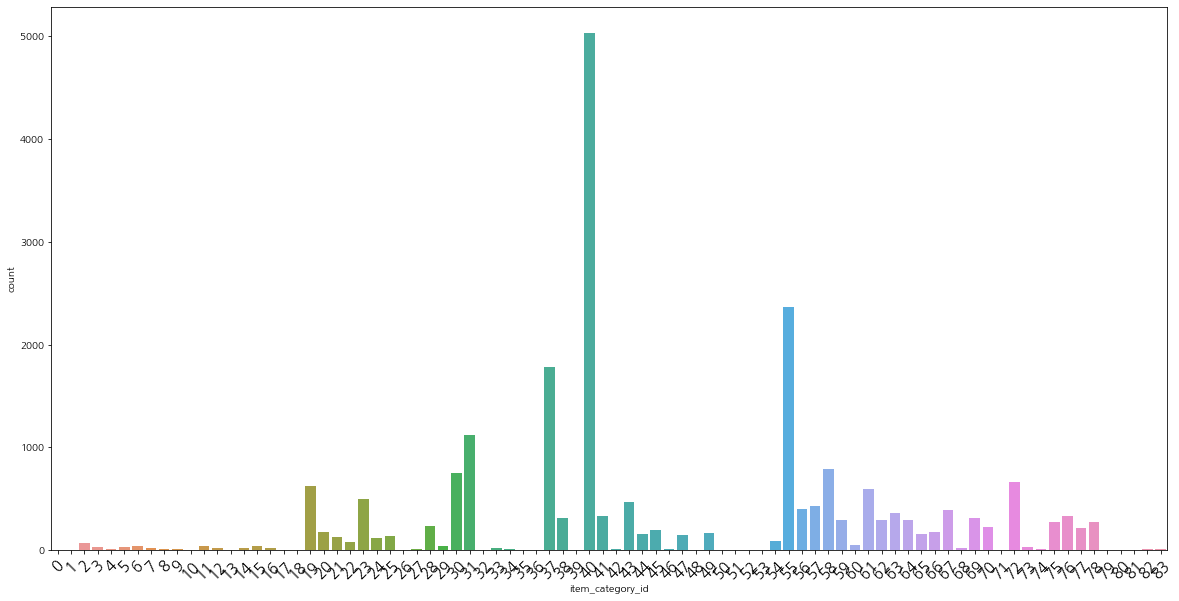

In [26]:
plt.figure(figsize=(20,10))
sns.countplot(x= 'item_category_id' , data = items)
plt.xticks(size = 15 , rotation =  45 , color = 'black')
plt.show()

- 특정 카테고리에 아이템이 몰려 있는 것을 확인 할 수 있다. 
- 이를 해결하기 위해 상위 카테고리를 분리 후 데이터가 수가 작은 카테고리는 기타 카테고리에 묶는 작업이 필요하다.

# item_category

In [27]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [28]:
item_categories.head(20)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


- item_category_name에 같은 단어가 들어가는 데이터가 많이 존재한다
- 이를 묶어 더 큰 범주를 만들 수 있다.

## high_category

- item_category의 앞부분만 자르고 새롭게 만든 열을 라벨인코딩 (악세사리 >> 1)   
- item_id와 연결되어있는 item_category를 새롭게 만든 열로 연결하여 test값을 예측한다면?

In [29]:
# item_category 분류하여 새로운 열 만들기
def make_high_category(data_name_col):
    '''
    상위 분류를 생성후 라벨 인코딩을 하는 함수
    shopname 과 item_category_name 에 사용
    '''
    data_name_col
    data_name_col = data_name_col.apply(clean_text)
    high_category_name = data_name_col.str.split(' ')
    high_category_name = [data[1] if data[0] == '' else data[0] for data in high_category_name]
    high_category_name_le = LabelEncoder()
    high_category_name_le.fit(high_category_name)
    high_category_id = high_category_name_le.transform(high_category_name)
    return high_category_name , high_category_id

### 아이템 상위 카테고리 high_category_name

In [30]:
item_categories['high_category_name'] , item_categories['high_category_id'] =\
make_high_category(item_categories.item_category_name)

In [31]:
item_categories_value_counts=item_categories['high_category_name'].value_counts()
print(item_categories_value_counts)
item_categories_value_counts =\
item_categories_value_counts[item_categories_value_counts<5].index

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Служебные      2
Чистые         2
PC             1
Билеты         1
Доставка       1
Элементы       1
Name: high_category_name, dtype: int64


- 아이템 종류가 5개 미만인 상위 카테고리는 etc로 묶어준다.

In [32]:
item_categories['high_category_name'] = \
item_categories['high_category_name'].apply(
    lambda x : 'etc' if x in item_categories_value_counts else x)

In [33]:
item_categories['high_category_name'].value_counts()

Игры          14
Книги         13
Подарки       12
etc            8
Игровые        8
Аксессуары     7
Музыка         6
Программы      6
Карты          5
Кино           5
Name: high_category_name, dtype: int64

### shop 상위 카테고리 city

In [34]:
shops['city_name'],shops['city_id'] = make_high_category(shops.shop_name)

In [35]:
shops.head(3)

,shop_name,shop_id,city_name,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0


## train + test 

In [36]:
'''
test에 없는 열을 추가 해야 하거나
train에 쓸모없는 데이터를 제거해야 한다. 
'''
test.columns , sales_df.columns

(Index(['ID', 'shop_id', 'item_id'], dtype='object'),
 Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
        'item_price_mean', 'item_count'],
       dtype='object'))

In [37]:
test['date_block_num'] = 34
del test['ID']

In [38]:
# 인덱스 값이 꼬여있다.
pd.concat([test,sales_df]).fillna(0)

,shop_id,item_id,date_block_num,item_cnt_month,item_price_mean,item_count
0,5,5037,34,0.0,0.0,0.0
1,5,5320,34,0.0,0.0,0.0
2,5,5233,34,0.0,0.0,0.0
3,5,5232,34,0.0,0.0,0.0
4,5,5268,34,0.0,0.0,0.0
...,...,...,...,...,...,...
8642756,21,7635,33,0.0,0.0,0.0
8642757,21,7638,33,0.0,0.0,0.0
8642758,21,7640,33,0.0,0.0,0.0
8642759,21,7632,33,0.0,0.0,0.0


In [39]:
pd.concat([test,sales_df])\
.fillna(0)\
.set_index(base_feature_names)\
.sort_index()\
.reset_index()\
.reset_index()\
.drop('index',axis = 1)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count
0,0,2,19,0.0,0.0,0.0
1,0,2,27,1.0,2499.0,1.0
2,0,2,28,0.0,0.0,0.0
3,0,2,29,0.0,0.0,0.0
4,0,2,32,0.0,0.0,0.0
...,...,...,...,...,...,...
8856956,34,59,22162,0.0,0.0,0.0
8856957,34,59,22163,0.0,0.0,0.0
8856958,34,59,22164,0.0,0.0,0.0
8856959,34,59,22166,0.0,0.0,0.0


In [40]:
sales_df =\
pd.concat([test,sales_df])\
.fillna(0)\
.set_index(base_feature_names)\
.sort_index()\
.reset_index()\
.reset_index()\
.drop('index',axis = 1)

## merging item , city data

In [41]:
sales_df = \
pd.merge(sales_df ,
         shops ,
         on =  'shop_id').drop(['shop_name','city_name'] ,axis =1)

In [42]:
sales_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,city_id
0,0,2,19,0.0,0.0,0.0,0
1,0,2,27,1.0,2499.0,1.0,0
2,0,2,28,0.0,0.0,0.0,0


In [43]:
item_high_categories =\
items.merge(item_categories).drop(['item_category_name','high_category_name'],axis = 1)

item_high_categories.head(3)

,item_id,item_category_id,first_sale_date,high_category_id
0,0,40,34,7
1,2,40,34,7
2,3,40,34,7


In [44]:
sales_df = pd.merge(sales_df ,item_high_categories ,on =  'item_id')

In [45]:
sales_df.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_count,city_id,item_category_id,first_sale_date,high_category_id
0,0,2,19,0.0,0.0,0.0,0,40,0,7
1,0,3,19,0.0,0.0,0.0,1,40,0,7
2,0,4,19,0.0,0.0,0.0,2,40,0,7


### add_month

In [46]:
sales_df['month'] = ((sales_df.date_block_num % 12) +1).astype(np.int8)

## 시각화

In [47]:
def draw_x_group_y_sum_barplot(x, y):
    temp_data_for_plot = \
    sales_df.pivot_table(index = x , values = y , aggfunc = np.sum).reset_index()
    plt.figure(figsize=(20,20))
    sns.barplot(x= x,
                y = y, 
                data = temp_data_for_plot)
    plt.title(f'{y}___per___{x}')
    plt.rc.fontsize = 20
    plt.show()

### date_block_num 별 팔린 횟수

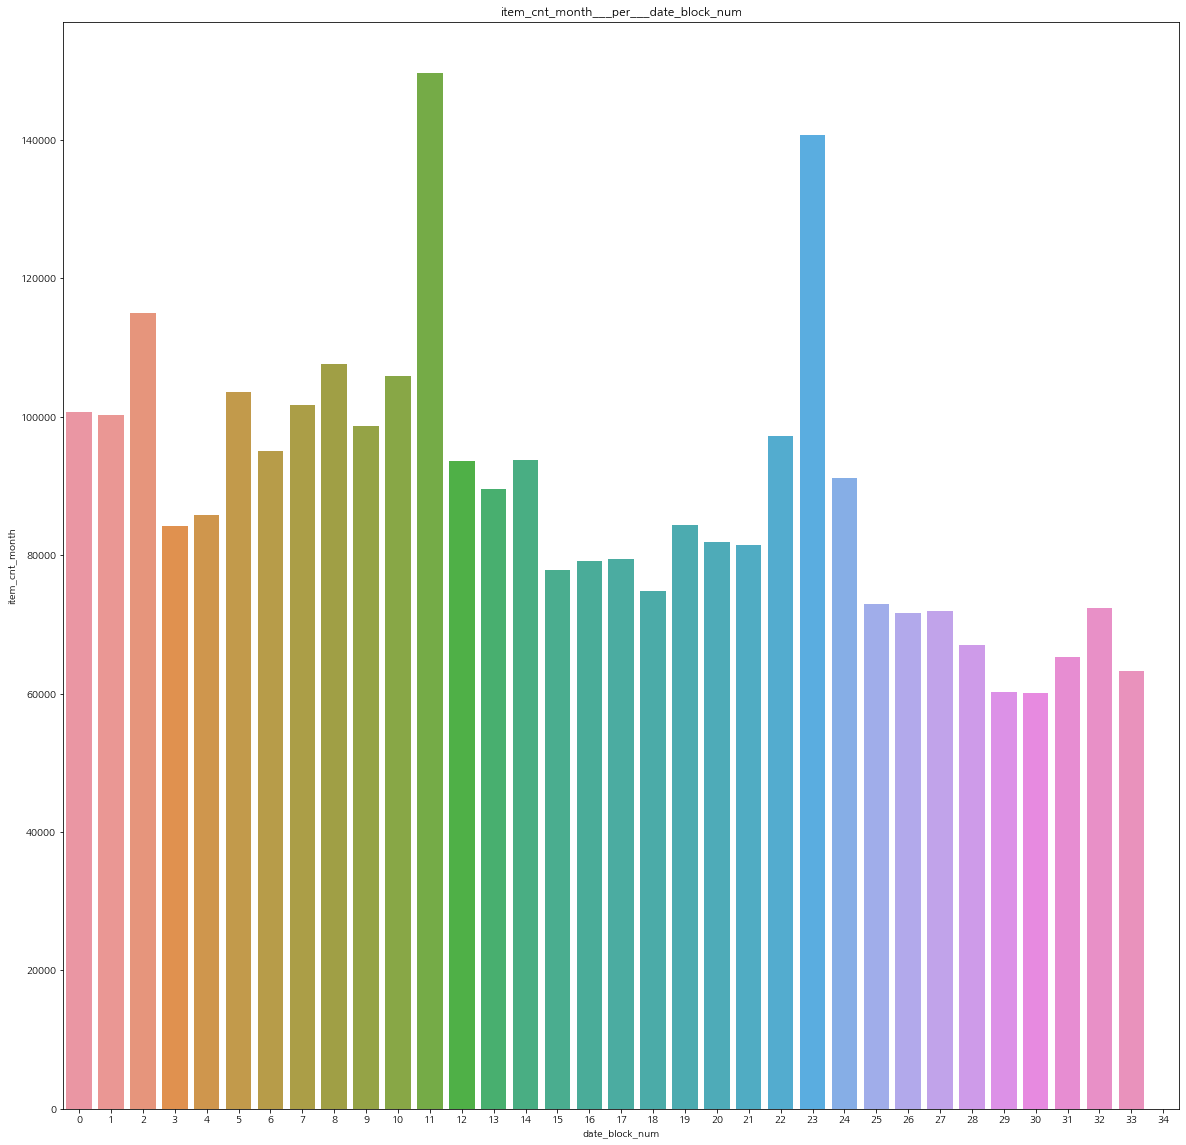

In [48]:
draw_x_group_y_sum_barplot('date_block_num','item_cnt_month')

### 달별 팔린 횟수 

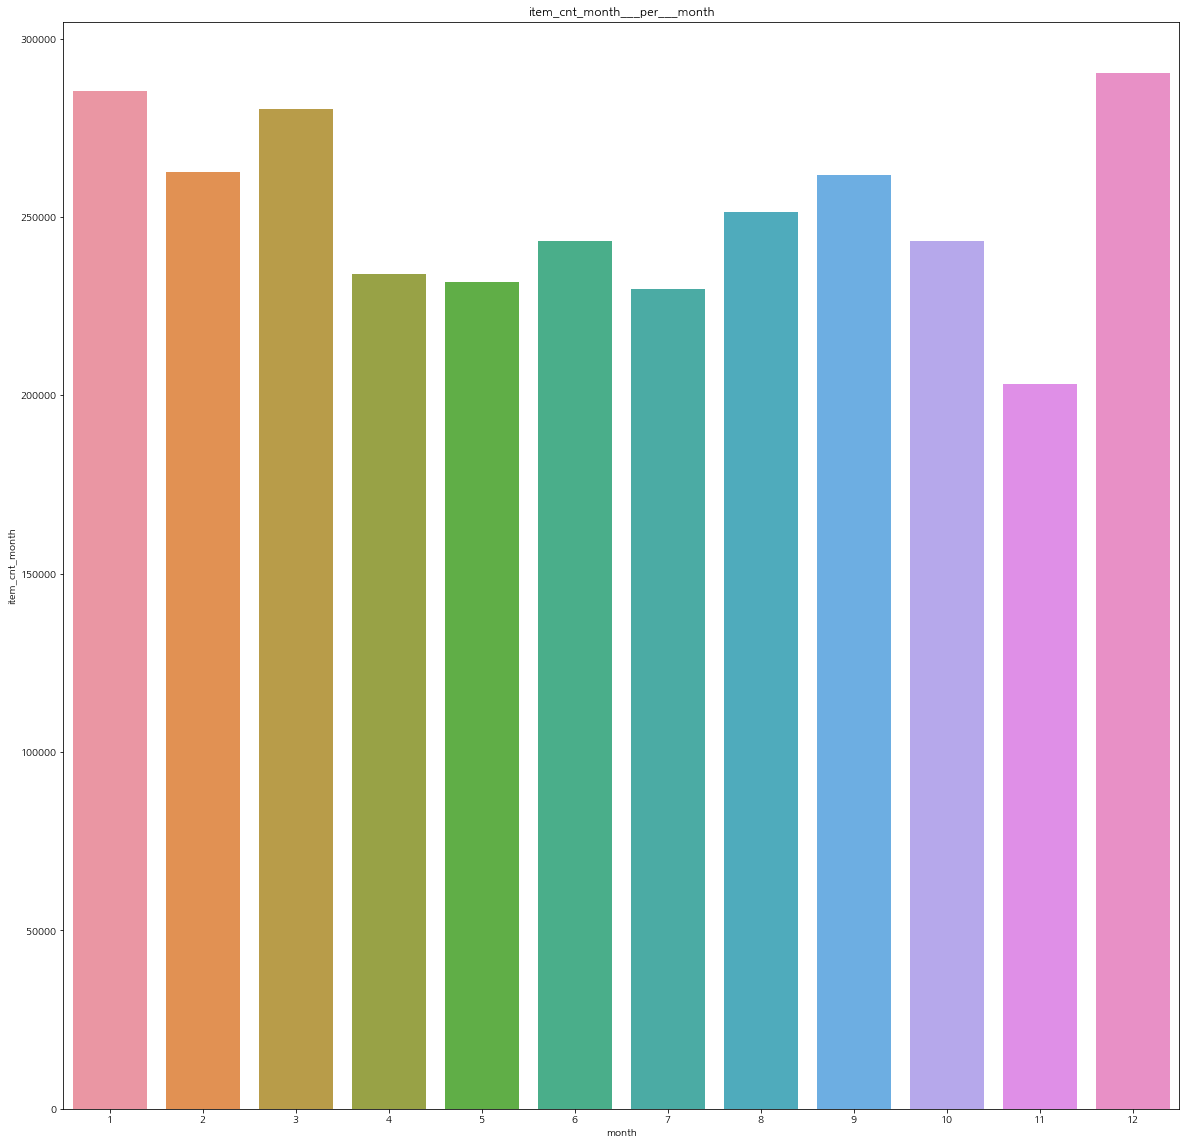

In [49]:
draw_x_group_y_sum_barplot('month','item_cnt_month')

In [50]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8856961 entries, 0 to 8856960
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_month    float64
 4   item_price_mean   float64
 5   item_count        float64
 6   city_id           int32  
 7   item_category_id  int64  
 8   first_sale_date   int32  
 9   high_category_id  int32  
 10  month             int8   
dtypes: float64(3), int32(3), int64(4), int8(1)
memory usage: 650.4 MB


## add_mean_feature

In [51]:
def add_mean_feature(df ,
                     base_feature_names ,
                     num_feature_name):
    '''
    base_feature_name를 기준으로 num_feature_name의 값의
    한달 평균을 구해서 df에 병합해주는 함수
    '''
    num_feature_name
    df_temp = df[base_feature_names + [num_feature_name]]
    if len(base_feature_names) not in [1, 2, 3]:
        raise
        
    if len(base_feature_names) == 1:
        feature_name = 'date_' +num_feature_name+'_mean'
    elif len(base_feature_names) == 2:
        feature_name = base_feature_names[1] +'_'+num_feature_name.split('_')[1]+ '_month_mean'
    else:
        feature_name = base_feature_names[1] + '_' + base_feature_names[2] +'_'+num_feature_name.split('_')[1]+'_month_mean'
    
    df_temp = df_temp.rename(columns = {num_feature_name:feature_name})
    print(f'{feature_name}이 생성되었습니다.')
    df_temp = df_temp.groupby(base_feature_names).agg({feature_name : np.mean}).reset_index()
    df = df.merge(df_temp ,
                  on =base_feature_names,
                  how= 'left') 
    return df , feature_name

In [52]:
def add_lag_data(df , base_feature_names,lag_feature,add_lag_feature_names, lag_periods= [1] , drop = True):
    '''
    lag_period 만큼의 시차 데이터를 생성하는 함수 
    '''
    
    df_temp = df[base_feature_names + [lag_feature]].copy()
    
    for i in lag_periods:
        feature_name  = lag_feature +"_lag_"+str(i)
        df_temp.columns = base_feature_names +[feature_name]
        df_temp['date_block_num'] +=i
        df = df.merge(df_temp.drop_duplicates(), 
                      on=base_feature_names, 
                      how='left')
        df[feature_name] = df[feature_name].fillna(0)
        print(f'{feature_name}을 생성하였습니다.')
        add_lag_feature_names.append(feature_name)
    if drop : 
        df = df.drop(columns = [lag_feature] ,axis =1)
    
    return df ,add_lag_feature_names
        

In [53]:
sales_df_backup = sales_df.copy()

In [54]:
sales_df = sales_df_backup.copy()

### 월별 평균

In [55]:
# 월별 아이템 팔린 갯수 평균
base_feature_names = ['date_block_num']
num_feature_name = 'item_cnt_month'
add_lag_feature_names = []
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1,2,3,6,12],
            False)


date_item_cnt_month_mean이 생성되었습니다.
date_item_cnt_month_mean_lag_1을 생성하였습니다.
date_item_cnt_month_mean_lag_2을 생성하였습니다.
date_item_cnt_month_mean_lag_3을 생성하였습니다.
date_item_cnt_month_mean_lag_6을 생성하였습니다.
date_item_cnt_month_mean_lag_12을 생성하였습니다.


In [56]:
# 월별 아이템 팔린 갯수 평균
base_feature_names = ['date_block_num','high_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1])

high_category_id_cnt_month_mean이 생성되었습니다.
high_category_id_cnt_month_mean_lag_1을 생성하였습니다.


In [57]:
base_feature_names = ['date_block_num','item_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1])

item_category_id_cnt_month_mean이 생성되었습니다.
item_category_id_cnt_month_mean_lag_1을 생성하였습니다.


### shop_id별 평균

In [58]:
#월 가게별 달 아이템 팔린 평균
base_feature_names = ['date_block_num','shop_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1,2,3,6,12])

shop_id_cnt_month_mean이 생성되었습니다.
shop_id_cnt_month_mean_lag_1을 생성하였습니다.
shop_id_cnt_month_mean_lag_2을 생성하였습니다.
shop_id_cnt_month_mean_lag_3을 생성하였습니다.
shop_id_cnt_month_mean_lag_6을 생성하였습니다.
shop_id_cnt_month_mean_lag_12을 생성하였습니다.


In [59]:
base_feature_names = ['date_block_num','shop_id','item_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1])

shop_id_item_category_id_cnt_month_mean이 생성되었습니다.
shop_id_item_category_id_cnt_month_mean_lag_1을 생성하였습니다.


In [60]:
base_feature_names = ['date_block_num','shop_id','high_category_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1])

shop_id_high_category_id_cnt_month_mean이 생성되었습니다.
shop_id_high_category_id_cnt_month_mean_lag_1을 생성하였습니다.


## 도시별

In [61]:
base_feature_names = ['date_block_num','city_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1])

city_id_cnt_month_mean이 생성되었습니다.
city_id_cnt_month_mean_lag_1을 생성하였습니다.


In [62]:
# 월 도시 아이템 별 팔린 갯수의 평균
base_feature_names = ['date_block_num','item_id','city_id']
num_feature_name = 'item_cnt_month'
sales_df ,num_feature_name =\
add_mean_feature(sales_df ,
                 base_feature_names,
                num_feature_name)
sales_df , add_lag_feature_names =\
add_lag_data(sales_df,
            base_feature_names,
            num_feature_name,
            add_lag_feature_names,
            [1])

item_id_city_id_cnt_month_mean이 생성되었습니다.
item_id_city_id_cnt_month_mean_lag_1을 생성하였습니다.


In [63]:
sales_df.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_price_mean', 'item_count', 'city_id', 'item_category_id',
       'first_sale_date', 'high_category_id', 'month',
       'date_item_cnt_month_mean', 'date_item_cnt_month_mean_lag_1',
       'date_item_cnt_month_mean_lag_2', 'date_item_cnt_month_mean_lag_3',
       'date_item_cnt_month_mean_lag_6', 'date_item_cnt_month_mean_lag_12',
       'high_category_id_cnt_month_mean_lag_1',
       'item_category_id_cnt_month_mean_lag_1', 'shop_id_cnt_month_mean_lag_1',
       'shop_id_cnt_month_mean_lag_2', 'shop_id_cnt_month_mean_lag_3',
       'shop_id_cnt_month_mean_lag_6', 'shop_id_cnt_month_mean_lag_12',
       'shop_id_item_category_id_cnt_month_mean_lag_1',
       'shop_id_high_category_id_cnt_month_mean_lag_1',
       'city_id_cnt_month_mean_lag_1', 'item_id_city_id_cnt_month_mean_lag_1'],
      dtype='object')

In [65]:
sales_df_backup = sales_df.copy()
sales_df = reduce_mem_usage(sales_df)

Mem. usage decreased to 481.46 Mb (73.2% reduction)


## add_trend_data

In [66]:
base_feature_names = ['date_block_num','item_id']
num_feature_name = 'item_price'
df_temp ,num_feature_name =\
add_mean_feature(train ,
                 base_feature_names,
                num_feature_name)


item_id_price_month_mean이 생성되었습니다.


In [72]:
sales_df[sales_df['item_price_mean']>0]['item_price_mean']

15           28.0
35         2500.0
49          498.0
61          998.0
78          498.0
            ...  
8840773     169.0
8840777     169.0
8840781     169.0
8840783     169.0
8840817     249.0
Name: item_price_mean, Length: 1332883, dtype: float16

### 처음 팔린 날부터  팔린 달까지 걸린시간

In [ ]:
sales_df['new'] = sales_df['first_sale_date'] == sales_df['date_block_num']

sales_df['duration_date'] = \
sales_df['date_block_num'] - sales_df['first_sale_date']

In [ ]:
sales_df['item_cnt_month_lag_mean'] = \
(sales_df['item_cnt_month_lag_1']+sales_df['item_cnt_month_lag_2']+sales_df['item_cnt_month_lag_3']) / 3

In [ ]:
sales_df['item_cnt_month_lag_grad_1'] =sales_df['item_cnt_month_lag_1']/sales_df['item_cnt_month_lag_2']
sales_df['item_cnt_month_lag_grad_1']= \
sales_df['item_cnt_month_lag_grad_1'].replace([np.inf, -np.inf],0).fillna(0)

sales_df['item_cnt_month_lag_grad_2'] =sales_df['item_cnt_month_lag_2']/sales_df['item_cnt_month_lag_3']
sales_df['item_cnt_month_lag_grad_2'] = \
sales_df['item_cnt_month_lag_grad_2'].replace([np.inf, -np.inf],0).fillna(0)

In [ ]:
# sales_df[add_feature_names + ['item_cnt_month', 'item_cnt_month_lag_mean']] = \
# sales_df[add_feature_names + ['item_cnt_month', 'item_cnt_month_lag_mean']].clip(0, 20)

In [ ]:
sales_df.info()

In [ ]:
catagory_feature_names = ['shop_id', 'city_id', 'item_category_id', 'high_category_id', 'month']
from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 
x = sales_df.drop(catagory_feature_names+, axis=1).values # 독립변인들의 value값만 추출
y = sales_df['item_cnt_month'].values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장

features = sales_df.drop(catagory_feature_names, axis=1).columns
pd.DataFrame(x, columns=features).head()

In [ ]:
sales_df = reduce_mem_usage(sales_df)
x_train = sales_df[sales_df['date_block_num'] < 33]
x_train = x_train.drop(['item_cnt_month'], axis = 1)
y_train = sales_df[sales_df['date_block_num'] < 33]['item_cnt_month']


x_valid = sales_df[sales_df['date_block_num'] == 33]
x_valid = x_valid.drop(['item_cnt_month'], axis = 1)
y_valid = sales_df[sales_df['date_block_num'] == 33]['item_cnt_month']

x_test = sales_df[sales_df['date_block_num'] == 34]
x_test = x_test.drop(['item_cnt_month'], axis = 1)
y_test = sales_df[sales_df['date_block_num'] == 34]['item_cnt_month']

In [ ]:
import lightgbm as lgb

catagory_feature_names = ['shop_id', 'city_id', 'item_category_id', 'high_category_id', 'month']

params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

# lgb train and valid dataset
dtrain = lgb.Dataset(x_train, y_train)
dvalid = lgb.Dataset(x_valid, y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=catagory_feature_names,
                      verbose_eval=100)     

In [ ]:
preds = lgb_model.predict(x_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

In [ ]:
lgb.plot_importance(lgb_model,figsize = (40,70))

In [ ]:
sales_df.columns

In [ ]:
sales_corr = sales_df.drop(columns = catagory_feature_names).corr() 
plt.figure(figsize=(20,20))
sns.heatmap(sales_corr, annot=True)
plt.show()

In [ ]:
len(preds>0)